# Analysis on Identifying Cats with AWS Rekognition API

## OS environment set up

First, we install and import packages for setup.

In [1]:
!mkdir temp

## Useful function used

This is a helper function to get the API's Cat's confidence. In this step, we want to define the label detection function, which only returns the label related to cats (body parts and color). In the function, we want to exclude the background labels. Labels defined in this function are top, left, width, height, and confidence.

In [22]:
import boto3
from botocore.errorfactory import ClientError
import PIL
import numpy as np


def detect_labels(photo, bucket, local, p = False):
    ## link to the AWS ML service
    client=boto3.client('rekognition')
    response = None
    ## provide option to read image from both local and s3 buckets
    if local:
        with open(photo, 'rb') as image_file:
            image = image_file.read()
            response = client.detect_labels(Image={'Bytes': image}, MaxLabels=10)
    else:
        response = client.detect_labels(Image={'S3Object':{'Bucket':bucket,'Name':photo}},
            MaxLabels=10)
    
    # optional logging
    if p:
        print('Detected cat labels for ' + photo) 
        print()
    found_cat = False
    for label in response['Labels']:
        if label['Name'] == 'Cat':
            found_cat = True
            for instance in label['Instances']:
                ## optional logging
                if p:
                    print ("  Bounding box")
                    print ("    Top: " + str(instance['BoundingBox']['Top']))
                    print ("    Left: " + str(instance['BoundingBox']['Left']))
                    print ("    Width: " +  str(instance['BoundingBox']['Width']))
                    print ("    Height: " +  str(instance['BoundingBox']['Height']))
                    print ("  Confidence: " + str(instance['Confidence']))
                    print()
            return found_cat, label
    return found_cat, 0

### A Sample Run on the above function

PIL (Python imaging library) helps with opening, manipulating, saving, and displaying our images. 

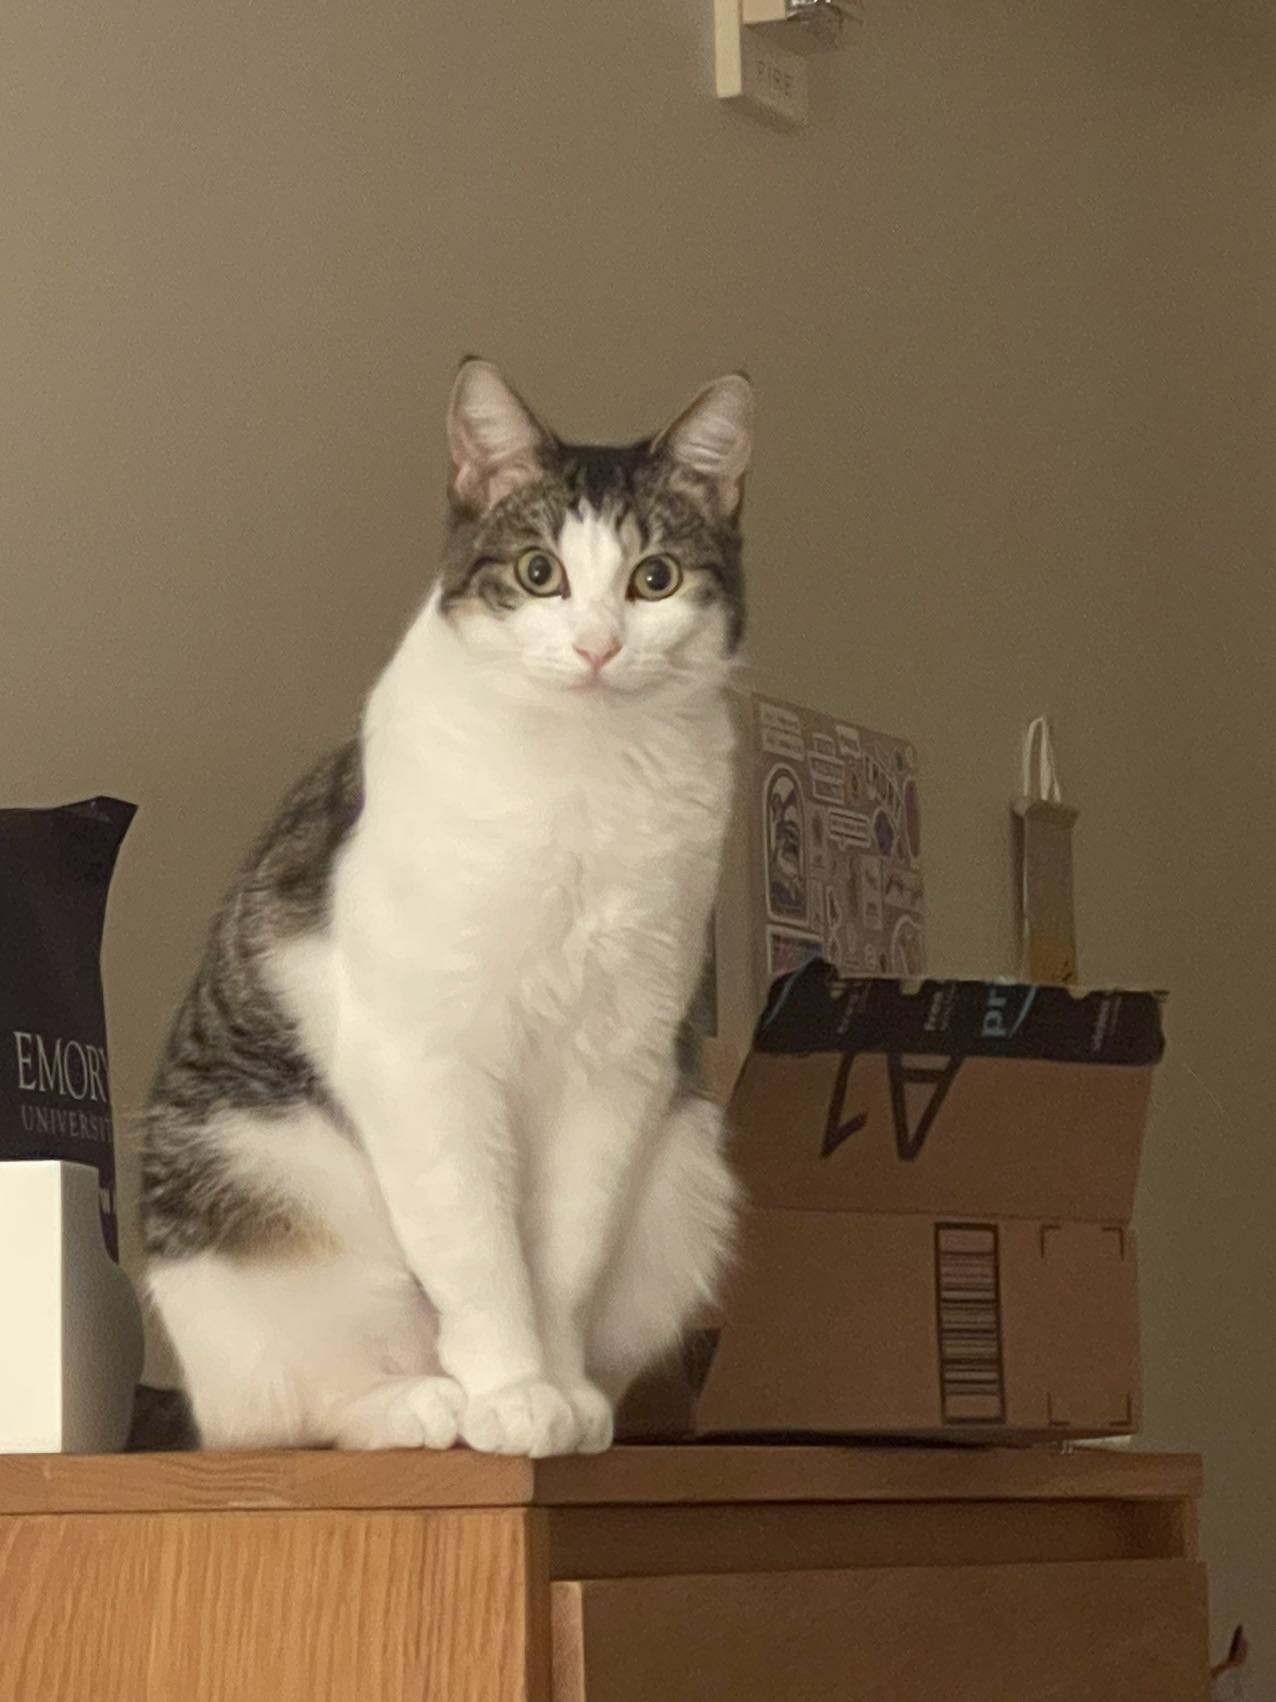

In [3]:
from PIL import Image
image = Image.open('img/sample_img/1181667592680_.pic.jpg')
display(image)

Below is a sample run that shows the sample result on the image.

In [4]:
res = detect_labels('1181667592680_.pic.jpg', 'qtm350project', False, True)
res

Detected cat labels for 1181667592680_.pic.jpg

  Bounding box
    Top: 0.20432382822036743
    Left: 0.09691555052995682
    Width: 0.4994608163833618
    Height: 0.6523746848106384
  Confidence: 95.3527603149414



(True,
 {'Name': 'Cat',
  'Confidence': 95.3527603149414,
  'Instances': [{'BoundingBox': {'Width': 0.4994608163833618,
     'Height': 0.6523746848106384,
     'Left': 0.09691555052995682,
     'Top': 0.20432382822036743},
    'Confidence': 95.3527603149414}],
  'Parents': [{'Name': 'Animal'}, {'Name': 'Mammal'}, {'Name': 'Pet'}],
  'Aliases': [],
  'Categories': [{'Name': 'Animals and Pets'}]})

We use the invert function to change a positive image to a negative image where the lightest areas of the cat are changed to the darkest and the darkest areas appear as the lightest.

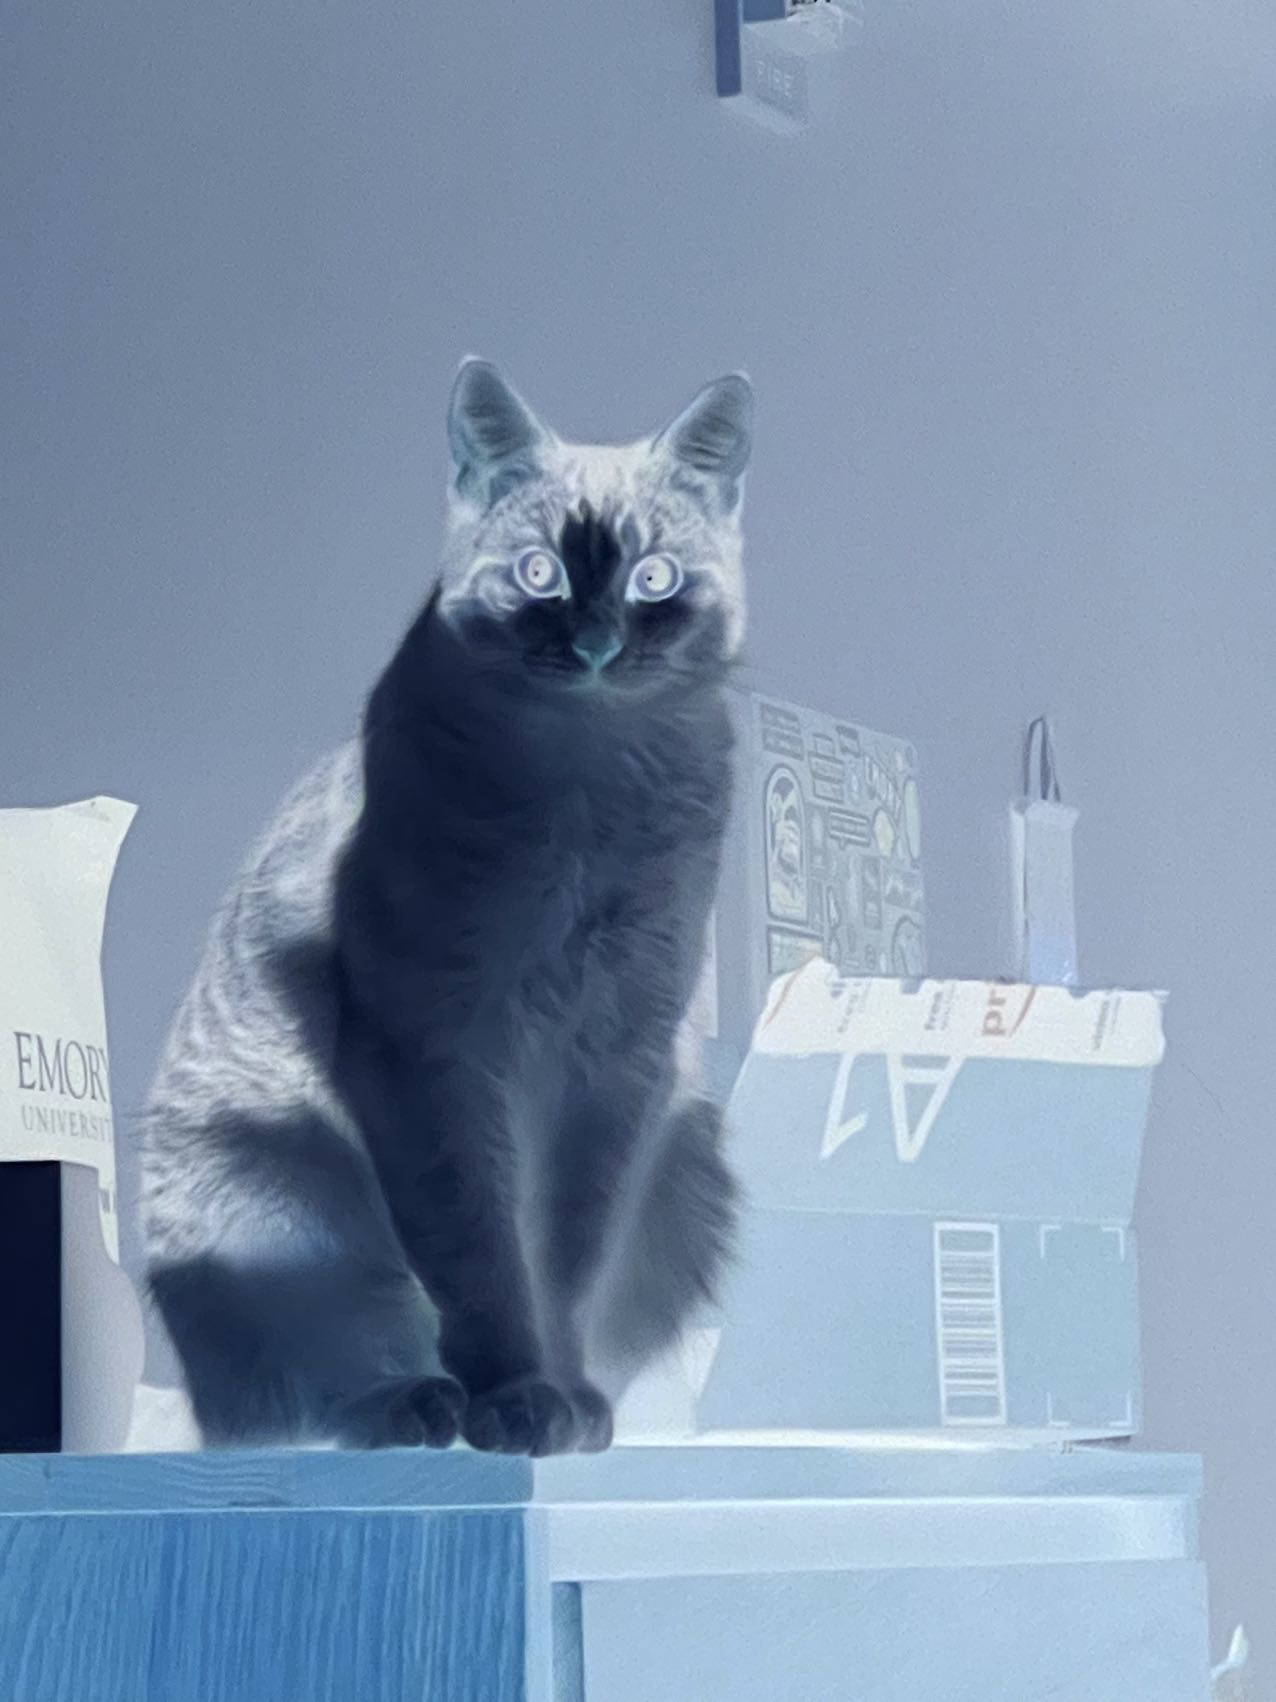

In [5]:
image_inv = PIL.ImageOps.invert(image)
display(image_inv)
image_inv.save('./img/sample_img/inv_1181667592680_.pic.jpg')

With manipulations on the image, we run the model again to test its functionality.

In [6]:
res = detect_labels('./img/sample_img/inv_1181667592680_.pic.jpg', 'qtm350project', True)
res

img read
<class 'bytes'>


(True,
 {'Name': 'Cat',
  'Confidence': 95.9192123413086,
  'Instances': [{'BoundingBox': {'Width': 0.49384722113609314,
     'Height': 0.6530063152313232,
     'Left': 0.1026424989104271,
     'Top': 0.20546340942382812},
    'Confidence': 95.9192123413086}],
  'Parents': [{'Name': 'Animal'}, {'Name': 'Mammal'}, {'Name': 'Pet'}],
  'Aliases': [],
  'Categories': [{'Name': 'Animals and Pets'}]})

## Analysis

### Get data

In the baseline run, all sample image taken by the group member would run through the AWS ML API
<!-- more explanation -->

We read all the image inputs and store them into our public S3 bucket, which is named as qtm350project. In order to check our progress, we print the image names.

In [7]:
s3_resource = boto3.resource('s3')
my_bucket = s3_resource.Bucket('qtm350project')
summaries = my_bucket.objects.all()
image_names = [image.key for image  in summaries]
image_names

['1181667592680_.pic.jpg',
 '1191667592682_.pic.jpg',
 '1201667592682_.pic.jpg',
 '1211667592683_.pic.jpg',
 '1221667592684_.pic.jpg',
 '1231667592685_.pic.jpg',
 '1241667592688_.pic.jpg',
 '1251667592691_.pic.jpg',
 '1261667592692_.pic.jpg',
 '1271667592693_.pic.jpg',
 '1281667592694_.pic.jpg',
 '1291667592695_.pic.jpg',
 '1301667592696_.pic.jpg',
 '1311667592697_.pic.jpg',
 '1321667592698_.pic.jpg',
 '1331667592699_.pic.jpg',
 '1341667592700_.pic.jpg',
 '1351667592702_.pic.jpg',
 '1361667592702_.pic.jpg',
 '1371667592703_.pic.jpg',
 'IMG_0590.jpg',
 'IMG_0606.jpg',
 'IMG_0608.JPG',
 'IMG_0611.jpg',
 'IMG_0622.JPG',
 'IMG_0639.jpg',
 'IMG_0642.jpg',
 'IMG_0695.jpg',
 'IMG_0699.jpg',
 'IMG_0729.jpg',
 'IMG_0859.jpg',
 'IMG_0863.jpg',
 'IMG_0886.jpg',
 'IMG_0931.jpg',
 'IMG_0945.jpg',
 'IMG_0962.JPG',
 'IMG_1250.jpg',
 'IMG_1380.jpg',
 'IMG_1424.jpg',
 'IMG_1425.jpg',
 'IMG_1443.jpg',
 'IMG_1454.jpg',
 'IMG_1506.JPG',
 'IMG_1530.jpg',
 'IMG_1547.jpg',
 'IMG_1639.jpg',
 'IMG_1641.jpg',
 

We fetch all images from S3 bucket. If we fail, it will print "Unable to get". We also wany yo test how different manipulations can impact the accuracy of the model. Hence, we decide to compare the results from original images, rotated images, cropped images, and blurred images. In each methods of manipulating the images, we also want to compare the difference between analyzing high resolution images and low resolution images.

In [8]:
! mkdir temp/original
! mkdir temp/rotate
! mkdir temp/crop
! mkdir temp/blur

In [9]:
for name in image_names:
    try:
        s3_resource.Bucket('qtm350project').download_file(name, f'temp/original/{name}')
    except:
        print(f'Unable to get {name}')

### Data Manipulation

Some data manipulation would be done on the original image to investigate the effect of how different operation would impact AWS ML performance.  
- Rotation
    - rotation of 60, 90, and 180 degrees would be discussed
- Cut and Shuffle
    - cut the image onto four pieces and rearrange it in different order
- Blur
    - blur the image by mean and motion

- #### Rotation

The below functiond allows us to rotate each image bu 60 degrees, 90 degrees, and 180 degrees. The manipulated imaged will be saved in the rotate folder of the temp folder. These new images will also be renamed according to their degrees of rotation for clarity.

In [10]:
import os

for item in os.listdir("temp/original/"):
    try:
        if "MX" not in item and "MEAN" not in item and "CROP" not in item:
            raw = PIL.Image.open("temp/original/" + item)
            raw.rotate(60).save("temp/rotate/ROTATE60" + item)
            raw.rotate(90).save("temp/rotate/ROTATE90" + item)
            raw.rotate(180).save("temp/rotate/ROTATE180" + item)
    except:
        print(item)

- #### Cut and Shuffle

We evenly cut each image in to 4 pieces, we randomly shuffle the order of all cutted images. Then, new images will be saved in the crop folder of the temp folder. In this way, we differentiate the processed images from the original inputs.

In [11]:
import random

def crop(img, rst):
    raw = np.array(img)
    h = raw.shape[0]
    w = raw.shape[1]
    divide1 = int(h/2)
    divide2 = int(w/2)
    scattered = {}
    scattered["p1"] = raw[0:divide1, 0:divide2]
    scattered["p2"] = raw[divide1:2*divide1, 0:divide2]
    scattered["p3"] = raw[0:divide1, divide2:2*divide2]
    scattered["p4"] = raw[divide1:2*divide1, divide2:2*divide2]
    
    raw_copy = np.copy(raw)
    raw_copy[0:divide1, 0:divide2] = scattered[rst[0]]
    raw_copy[divide1:2*divide1, 0:divide2] = scattered[rst[1]]
    raw_copy[0:divide1, divide2:2*divide2] = scattered[rst[2]]
    raw_copy[divide1:2*divide1, divide2:2*divide2] = scattered[rst[3]] 
    return raw_copy

def get_order():
    flag = True
    order = None
    while flag:
        order = random.sample(["p1","p2","p3","p4"],4)
        if ["p1","p2","p3","p4"] != order:
            flag = False
    return order

fs = os.listdir("temp/original/")
for item in fs:
    #PIL.Image.fromarray(crop(Image.open("temp/original/" + item), get_order())).save("temp/crop/" + item)
    try:
        PIL.Image.fromarray(crop(Image.open("temp/original/" + item), get_order())).save("temp/crop/" + item)
    except:
        print("Problem:" + item)

- #### Blur 待改

With the code below, we blurred the images in two ways. One is by mean while the other is by motion. New images will be saved in the blur folder of the temp folder. The images will be renamed by their methods of blurring.

In [12]:
import cv2
import numpy as np
import os

def meanBlur(image,save_path):
    dst2 = cv2.medianBlur(image, 15)
    cv2.imwrite(save_path, dst2)
    return

# This function is referenced from the blog: https://blog.csdn.net/Wadewhl/article/details/112998830
def motionBlur(image, save_path, degree= 15, angle=45):
    image = np.array(image)
    # higher the degree, more blurred the image
    M = cv2.getRotationMatrix2D((degree / 2, degree / 2), angle, 1)
    motion_blur_kernel = np.diag(np.ones(degree))
    motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, M, (degree, degree))
    motion_blur_kernel = motion_blur_kernel / degree
    blurred = cv2.filter2D(np.float32(image), -1, motion_blur_kernel)
    cv2.normalize(blurred, blurred, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite(save_path, blurred)
    return

fs = os.listdir("temp/original/")
for item in fs:
    try:
        image = cv2.imread(f'temp/original/{item}')
        meanBlur(image, f'temp/blur/mean_{item}')
        motionBlur(image, f'temp/blur/motion_{item}')
    except:
        print("Problem:" + item)

### Run ML API
Below is a helper funtion to run ML API on all files in a given directory

In [20]:
def predict(dir_path):
    rsts = {}
    ls = os.listdir(dir_path)
    for l in ls:
        try:
            res = detect_labels(dir_path + l, None, True)
            rsts[l] = res
        except:
            print(f'Error in running ML API on {l}')
    return rsts

- #### Baseline Run
In the baseline run, all sample image taken by the group member would run through our ML model. In this attempt, all the images we are analyzing are the original, unaltered images we initially uploaded.

In [ ]:
conf_orig = predict("temp/original/")
dict(list(conf_orig.items())[:10])

- #### Rotation Run

In the rotation run, all the rotated image would run through our ML model. In this attempt, all the images we are analyzing are either rotated by 60, 90, or 180 degrees.

In [15]:
conf_rot = predict("temp/rotate/")
dict(list(conf_rot.items())[:10])

Error in running ML API on ROTATE60IMG_1250.jpg
Error in running ML API on ROTATE1801281667592694_.pic.jpg
Error in running ML API on ROTATE90IMG_2380.jpg
Error in running ML API on ROTATE60IMG_2336.JPG
Error in running ML API on ROTATE180IMG_0859.jpg
Error in running ML API on ROTATE180IMG_1250.jpg
Error in running ML API on ROTATE601291667592695_.pic.jpg
Error in running ML API on ROTATE90IMG_1639.jpg
Error in running ML API on ROTATE60IMG_1641.jpg
Error in running ML API on ROTATE1801301667592696_.pic.jpg
Error in running ML API on ROTATE180IMG_1380.jpg
Error in running ML API on ROTATE60IMG_2399.jpg
Error in running ML API on ROTATE90IMG_2336.JPG
Error in running ML API on ROTATE90IMG_4340.jpg
Error in running ML API on ROTATE1801331667592699_.pic.jpg
Error in running ML API on ROTATE60IMG_1547.jpg
Error in running ML API on ROTATE901361667592702_.pic.jpg
Error in running ML API on ROTATE180IMG_2332.jpg
Error in running ML API on ROTATE90IMG_0642.jpg
Error in running ML API on ROTA

{}

- #### Cut and Shuffle Run

In the cut and shuffle run, all the cropped image would run through our ML model. In this attempt, all the images we are analyzing are cropped from the original input images, and their order has been randomly shuffled to avoid bias.

In [16]:
conf_crop = predict("temp/crop/")
dict(list(conf_crop.items())[:10])

Error in running ML API on IMG_0590.jpg
Error in running ML API on IMG_1454.jpg
Error in running ML API on IMG_0695.jpg
Error in running ML API on 1341667592700_.pic.jpg
Error in running ML API on IMG_1250.jpg
Error in running ML API on IMG_0699.jpg
Error in running ML API on IMG_4440.jpg
Error in running ML API on IMG_2335.JPG
Error in running ML API on IMG_0611.jpg
Error in running ML API on IMG_1917.JPG
Error in running ML API on IMG_0639.jpg
Error in running ML API on IMG_1643.jpg
Error in running ML API on 1331667592699_.pic.jpg
Error in running ML API on IMG_2380.jpg
Error in running ML API on 1231667592685_.pic.jpg
Error in running ML API on IMG_0931.jpg
Error in running ML API on IMG_2334.JPG
Error in running ML API on IMG_1639.jpg
Error in running ML API on IMG_0729.jpg
Error in running ML API on 1281667592694_.pic.jpg
Error in running ML API on IMG_0622.JPG
Error in running ML API on 1201667592682_.pic.jpg
Error in running ML API on IMG_0962.JPG
Error in running ML API on 136

{}

- #### Blur Run

In the blur run, all the blurred image would run through our ML model. In this attempt, all the images we are analyzing are blurred either by mean or motion.

In [17]:
conf_blur = predict("temp/blur/")
dict(list(conf_blur.items())[:10])

Error in running ML API on mean_1341667592700_.pic.jpg
Error in running ML API on motion_1261667592692_.pic.jpg
Error in running ML API on mean_1311667592697_.pic.jpg
Error in running ML API on motion_IMG_0859.jpg
Error in running ML API on mean_IMG_2189.jpg
Error in running ML API on motion_IMG_2335.JPG
Error in running ML API on motion_1351667592702_.pic.jpg
Error in running ML API on mean_IMG_0622.JPG
Error in running ML API on motion_IMG_2311.JPG
Error in running ML API on mean_IMG_1454.jpg
Error in running ML API on motion_IMG_1707.jpg
Error in running ML API on motion_IMG_0639.jpg
Error in running ML API on motion_IMG_1547.jpg
Error in running ML API on motion_IMG_1641.jpg
Error in running ML API on mean_IMG_0608.JPG
Error in running ML API on mean_1361667592702_.pic.jpg
Error in running ML API on mean_IMG_0590.jpg
Error in running ML API on motion_IMG_0729.jpg
Error in running ML API on motion_IMG_2336.JPG
Error in running ML API on motion_1371667592703_.pic.jpg
Error in running

{}

### Analysis on the effect of rotation

### Analysis on the effect of clarity